<a href="https://colab.research.google.com/github/OpetherMB/grand-debat/blob/main/grand_debat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a class="anchor" id="1"></a> 

Dans ce projet on va essayer de faire une analyse des données ecologique lors de grand debat national 2019, dans la limite de temps qui était imposer pour ce teste on peut pas malheuresement faire une étude profonde.

ce que je vous propose c'est de commencer par une carte pour montrer le pourcentage des gens qu'ils ont contirbuer  à l'etudes par villes.

puis on va s'interesser  à 3  colonnes  'title',  'problems', 'reponse_probleme'
pour faire des stats et des clusters

## Librairies

In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
from collections import Counter
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
stemmer = FrenchStemmer()
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install wordcloud
from gensim import matutils, models
import scipy.sparse
from keras.preprocessing.text import Tokenizer
import folium
import pickle
from folium.plugins import HeatMap
import glob
import matplotlib.dates as mdates
import datetime as dt

nltk.download('wordnet')
# spacy for lemmatization
import spacy
!python -m spacy download fr




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 14.7MB 16.6MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp36-none-any.whl size=14727027 sha256=8368cfacb15036335a741f90c74367ccab8da884f741b5842415851e7506e89b
  Stored in directory: /tmp/pip-ephem-wheel-cache-iku6grko/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import data

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/Colab Notebooks/grand debat
!pwd

/content/drive/MyDrive/Colab Notebooks/grand debat
/content/drive/MyDrive/Colab Notebooks/grand debat


In [8]:
# local libraries
import util_preproc as util

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
environment_pd = pd.read_csv('LA_TRANSITION_ECOLOGIQUE.csv.xz', low_memory=False)
environment_pd.head()

,id,reference,title,createdAt,publishedAt,updatedAt,trashed,trashedStatus,authorId,authorType,authorZipCode,QUXVlc3Rpb246MTYw - Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?,QUXVlc3Rpb246MTYx - Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?,QUXVlc3Rpb246MTQ2 - Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?,"QUXVlc3Rpb246MTQ3 - Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?","QUXVlc3Rpb246MTQ4 - À titre personnel, pensez-vous pouvoir contribuer à protéger l'environnement ?","QUXVlc3Rpb246MTQ5 - Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?","QUXVlc3Rpb246MTUw - Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?",QUXVlc3Rpb246MTUx - Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?,"QUXVlc3Rpb246MTUy - Par rapport à votre mode de chauffage actuel, pensez-vous qu'il existe des solutions alternatives plus écologiques ?","QUXVlc3Rpb246MTUz - Si oui, que faudrait-il faire pour vous convaincre ou vous aider à changer de mode de chauffage ?","QUXVlc3Rpb246MTU0 - Avez-vous pour vos déplacements quotidiens la possibilité de recourir à des solutions de mobilité alternatives à la voiture individuelle comme les transports en commun, le covoiturage, l'auto-partage, le transport à la demande, le vélo, etc. ?","QUXVlc3Rpb246MTU1 - Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser ces solutions alternatives ?","QUXVlc3Rpb246MjA3 - Si non, quelles sont les solutions de mobilité alternatives que vous souhaiteriez pouvoir utiliser ?",QUXVlc3Rpb246MTU3 - Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?,QUXVlc3Rpb246MTU4 - Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?,QUXVlc3Rpb246MTU5 - Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?
0,UHJvcG9zYWw6ZmZlN2MwNzktMWUyMC0xMWU5LTk0ZDItZm...,2-4,transition écologique,2019-01-22 09:37:49,2019-01-22 09:37:49,NaN,False,NaN,VXNlcjoxMTQwMTc0YS0xZTFmLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,97231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enseignement du tri sélectif à l'école,Multiplier les centrales géothermiques
1,UHJvcG9zYWw6M2RmZmUxZjMtMWUyMS0xMWU5LTk0ZDItZm...,2-5,La surpopulation,2019-01-22 09:39:33,2019-01-22 09:39:33,NaN,False,NaN,VXNlcjpjOWYxZWQ1NS0xYzEwLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,57000,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mettre en oeuvre au niveau national ses engage...,Les problèmes auxquels se trouve confronté l’e...
2,UHJvcG9zYWw6NDg1YWUxYjItMWUyMS0xMWU5LTk0ZDItZm...,2-6,climat,2019-01-22 09:39:50,2019-01-22 09:39:50,NaN,False,NaN,VXNlcjozZjlhNzAwOS0xYTc2LTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,34140,"Les dérèglements climatiques (crue, sécheresse)",pour éviter les inondations obliger les rivera...,Non,NaN,Non,NaN,"développer les transports en commun ,",NaN,Non,NaN,Oui,NaN,Les transports en commun|L'auto partage|Le tra...,NaN,NaN,NaN
3,UHJvcG9zYWw6NTk2Nzk5MmItMWUyMS0xMWU5LTk0ZDItZm...,2-7,POLLUTION AIR EAU,2019-01-22 09:40:19,2019-01-22 09:40:19,NaN,False,NaN,VXNlcjozOWQwNzJjNC0xZDEwLTExZTktOTRkMi1mYTE2M2...,Citoyen / Citoyenne,17400,La pollution de l'air,Il faut taxer les gros pollueurs : Entreprises...,Non,NaN,Non,NaN,NaN,Plus de transports publics dans les petites co...,Non,NaN,Non,Le co-voiturage ne correspond pas toujours aux...,Les transport

In [10]:
environment_pd.shape

(87562, 27)

## 2. Reduced Data

In [11]:
# Nous allons explorer les deux premières questions et les nommer comme suit :
# Q1 : problems
# Q2 : reponse_probleme
# les autres questions seront intitulées Qi , i de 3 à 16

environment_pd.columns= ['id', 'reference', 'title', 'createdAt', 'publishedAt', 'updatedAt',
       'trashed', 'trashedStatus', 'authorId', 'authorType', 'authorZipCode', 'problems', 'reponse_probleme', 'q3','q4','q5','q6','q7','q8','q9','q10','q11','q12','q13','q14','q15','q16']

In [12]:
# convert to string
environment_pd[['problems', 'reponse_probleme', 'q3','q4','q5','q6','q7','q8','q9','q10','q11','q12','q13','q14','q15','q16']] = environment_pd[['problems', 'reponse_probleme', 'q3','q4','q5','q6','q7','q8','q9','q10','q11','q12','q13','q14','q15','q16']].astype(str)

In [13]:
#Define the new df containing clean data
reduced_dataset_df = environment_pd[['authorZipCode', 'title', 'problems', 'reponse_probleme']]
reduced_dataset_df.head()

,authorZipCode,title,problems,reponse_probleme
0,97231,transition écologique,nan,nan
1,57000,La surpopulation,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...
2,34140,climat,"Les dérèglements climatiques (crue, sécheresse)",pour éviter les inondations obliger les rivera...
3,17400,POLLUTION AIR EAU,La pollution de l'air,Il faut taxer les gros pollueurs : Entreprises...
4,35430,Economie vs Ecologie,La biodiversité et la disparition de certaines...,"Changer notre mode de vie, impulser une nouvel..."


<a class="anchor" id="3"></a> 

## 3. Distribution of responses in France (MAP)

In [14]:
# comme plusieurs gens on va utiliser un fichier qui permet de faire un mapping de zip et les villes en france,
#  note on peut aussi utiliser un api comme celui de google mais pour facilité la compilation de votre part on va utiliser un fichier csv que je vous envoie par mail aussi

cp_coord = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/grand debat/code-insee-postaux-geoflar.csv', encoding="ISO-8859-1", sep=";")
cp_coord = cp_coord[['CODE POSTAL', 'geom_x_y', 'NOM DE LA COMMUNE']]
cp_coord = cp_coord.dropna(subset=['geom_x_y'])
cp_coord.to_csv('cp.csv')

cp = pd.read_csv('cp.csv')

cp.head()

,Unnamed: 0,CODE POSTAL,geom_x_y,NOM DE LA COMMUNE
0,0,1360,"45.8591464826,5.13989505865",BELIGNEUX
1,1,1470,"45.8374974718,5.48285330863",BENONCES
2,2,1800,"45.8736786869,5.2211032563",CHARNOZ SUR AIN
3,3,1320,"45.9748017433,5.2416027725",CHATILLON LA PALUD
4,4,1190,"46.38249255,4.96288275972",CHEVROUX


In [15]:
#Compter le nombre de réponses par code postal

list_cp = cp['CODE POSTAL'].tolist()
n = len(list_cp)
list_rep = [0 for k in range(n)]
total = [0 for k in range(100000)]

for code in environment_pd['authorZipCode']:
    if 0 < code < 100000:
        total[int(code)] += 1

for k in range(n):
    if total[list_cp[k]] != 0:
        list_rep[k] = total[list_cp[k]]

In [16]:
# centrer la carte sur la france
map = folium.Map(location=[46.6055983, 1.8750922], zoom_start=5.5)

intensity, maximum = [], 0
for k in range(n):
    if list_rep[k] != 0:
        xy = cp['geom_x_y'][k]
        x, y = float(xy.split(',')[0]), float(xy.split(',')[1])
        intensity.append([x, y, list_rep[k]])
        maximum = max(maximum, list_rep[k])

heat_map = HeatMap(intensity,
                   min_opacity=0.1,
                   max_val=maximum,
                   radius=10, blur=10, 
                   max_zoom=2, 
                 )

map.add_child(heat_map)
map

la distribution ca peut etre du  à la densité de  population ou/et les gens sont plus intéresse par  ce probleme et ca leurs concerne plus ! il faut plus d'etude pour confirmer les deux hypothese comme faire une etude de densité de population par region 

<a class="anchor" id="4"></a> 

# 4. Preprocessing

Dans cette section, nous allons explorer différentes parties de l'ensemble de données. Et nous commencerons par la colonne "title" et construirons un 'world cloud'  représentant les expressions les plus utilisées.
Avant cela, nous allons :

* Faire tout en minuscules
* Supprimer la ponctuation
* Supprimer les valeurs numériques ( garder que textes)
* Texte à tokeniser (tokenization)
* Supprimer les  stop word
* Et plus encore...

###### The number of NaN of each column

In [17]:
# Let's count the nans for each column
environment_pd.isnull().sum()

id                      0
reference               0
title                   0
createdAt               0
publishedAt             1
updatedAt           82570
trashed                 0
trashedStatus       87552
authorId                0
authorType          15456
authorZipCode           0
problems                0
reponse_probleme        0
q3                      0
q4                      0
q5                      0
q6                      0
q7                      0
q8                      0
q9                      0
q10                     0
q11                     0
q12                     0
q13                     0
q14                     0
q15                     0
q16                     0
dtype: int64

In [18]:
# As we can see, there are many nan values for several columns so we have to remove them

In [19]:
# supprimer les nan
environment_pd.fillna('', inplace = True)

In [20]:
#  compter les Nans
environment_pd.isnull().sum()

id                  0
reference           0
title               0
createdAt           0
publishedAt         0
updatedAt           0
trashed             0
trashedStatus       0
authorId            0
authorType          0
authorZipCode       0
problems            0
reponse_probleme    0
q3                  0
q4                  0
q5                  0
q6                  0
q7                  0
q8                  0
q9                  0
q10                 0
q11                 0
q12                 0
q13                 0
q14                 0
q15                 0
q16                 0
dtype: int64

In [21]:
# # Voyons un exemple de réponses
environment_pd.iloc[1]

id                  UHJvcG9zYWw6M2RmZmUxZjMtMWUyMS0xMWU5LTk0ZDItZm...
reference                                                         2-5
title                                                La surpopulation
createdAt                                         2019-01-22 09:39:33
publishedAt                                       2019-01-22 09:39:33
updatedAt                                                            
trashed                                                         False
trashedStatus                                                        
authorId            VXNlcjpjOWYxZWQ1NS0xYzEwLTExZTktOTRkMi1mYTE2M2...
authorType                                        Citoyen / Citoyenne
authorZipCode                                                   57000
problems            Les problèmes auxquels se trouve confronté l’e...
reponse_probleme    Les problèmes auxquels se trouve confronté l’e...
q3                                                                nan
q4                  

<a class="anchor" id="4.1"></a> 

# 6. Analyse Title Column :


Nous avons choisi de commencer par explorer la colonne "title" afin d'en extraire les grands problèmes écologiques

In [22]:
clean_titles=util.clean_X(reduced_dataset_df['title'])
tokenized_titles= util.tokenization(clean_titles)
print(tokenized_titles[0:10])

[['transition', 'ecologique'], ['la', 'surpopulation'], ['climat'], ['pollution', 'air', 'eau'], ['economie', 'vs', 'ecologie'], ['egalite', 'territoriale', 'de', 'traitement'], ['nous', 'sommes', 'les', 'gardiens', 'de', 'la', 'terre', 'et', 'des', 'passeurs', 'pour', 'nos', 'enfants'], ['pollution', 'de', 'la', 'planete'], ['imposer', 'une', 'ecotaxe', 'aux', 'compagnies', 'maritimes', 'et', 'd', 'aviation'], ['ferroutage']]


In [23]:

filtered_titles= util.rmStopwords(tokenized_titles)
print(filtered_titles[0:10])

[['transition', 'ecologique'], ['surpopulation'], ['climat'], ['pollution', 'air', 'eau'], ['economie', 'vs', 'ecologie'], ['egalite', 'territoriale', 'traitement'], ['gardiens', 'terre', 'passeurs', 'enfants'], ['pollution', 'planete'], ['imposer', 'ecotaxe', 'compagnies', 'maritimes', 'aviation'], ['ferroutage']]


In [24]:
util.N_mostFreq(filtered_titles , 50)

[('ecologique', 7114), ('ecologie', 6914), ('transition', 6750), ('environnement', 3396), ('planete', 2340), ('pollution', 2193), ('transports', 2086), ('energie', 1726), ('taxer', 1456), ('urgence', 1418), ('transport', 1393), ('stop', 1362), ('climatique', 1344), ('energetique', 1314), ('developper', 1266), ('etre', 1244), ('energies', 1218), ('politique', 1192), ('produits', 1191), ('france', 1187), ('changer', 1162), ('vie', 1159), ('favoriser', 1127), ('pollueurs', 1115), ('taxe', 1103), ('enfants', 1096), ('commun', 1094), ('consommation', 1085), ('contre', 1081), ('agir', 1059), ('agriculture', 1052), ('avenir', 1049), ('priorite', 1034), ('biodiversite', 1015), ('dechets', 981), ('developpement', 974), ('nucleaire', 956), ('entreprises', 947), ('monde', 935), ('economie', 930), ('changement', 921), ('air', 887), ('etat', 881), ('reduire', 860), ('climat', 849), ('bio', 844), ('terre', 837), ('mieux', 832), ('bon', 820), ('sens', 820)]


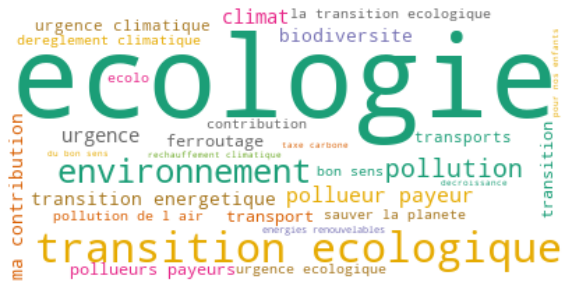

In [25]:
util.word_cloud(util.clean_X(reduced_dataset_df['title']))

Comme on peut le voir, il existe différentes variantes grammaticales et sémantiques de certains mots tels que "écologie". Nous devons donc réduire le déséquilibre des données en projetant des données rares et uniques
des variantes des mots sur la même représentation.

## Word cloud with * limmetized * words



In [26]:
lemm_titles= util.lemmetize(reduced_dataset_df['title'])
print(lemm_titles[0:10])

['transition', 'surpopulation', 'climat', 'pollution AIR eau', 'economie ecologie', 'égalité traitement', 'gardien terre passeur enfant', 'pollution planete', 'écotaxe compagnie aviation', 'ferroutage']


In [27]:
clean_titles= util.clean_X(lemm_titles)

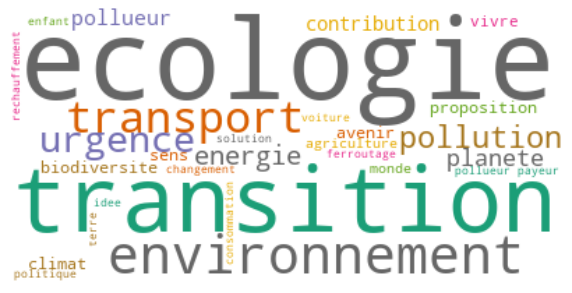

In [28]:
util.word_cloud(clean_titles)

##  Bigrams and trigrams * BEFORE * preprocessiing and removing stopwords

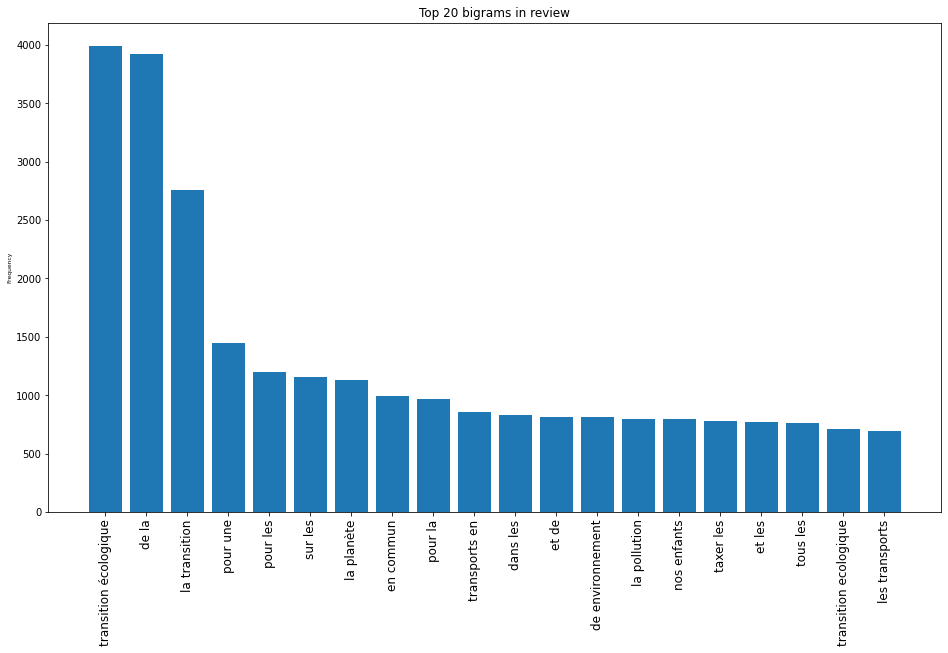

In [29]:
util.bigrams(reduced_dataset_df['title'], 20)

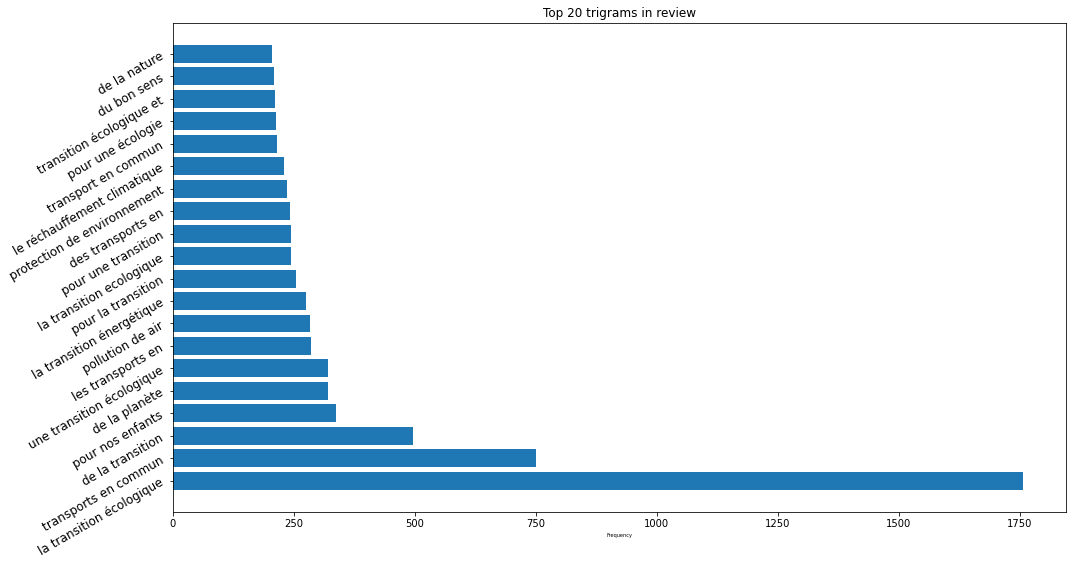

In [30]:
util.trigrams(reduced_dataset_df['title'], 20)

## Determine bigrams and trigrams * AFTER * preprocessiing and removing stopwords



In [31]:
reduced_dataset_df['clean_title'] = [' '.join(words) for words in filtered_titles]
reduced_dataset_df.head()

,authorZipCode,title,problems,reponse_probleme,clean_title
0,97231,transition écologique,nan,nan,transition ecologique
1,57000,La surpopulation,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...,surpopulation
2,34140,climat,"Les dérèglements climatiques (crue, sécheresse)",pour éviter les inondations obliger les rivera...,climat
3,17400,POLLUTION AIR EAU,La pollution de l'air,Il faut taxer les gros pollueurs : Entreprises...,pollution air eau
4,35430,Economie vs Ecologie,La biodiversité et la disparition de certaines...,"Changer notre mode de vie, impulser une nouvel...",economie vs ecologie


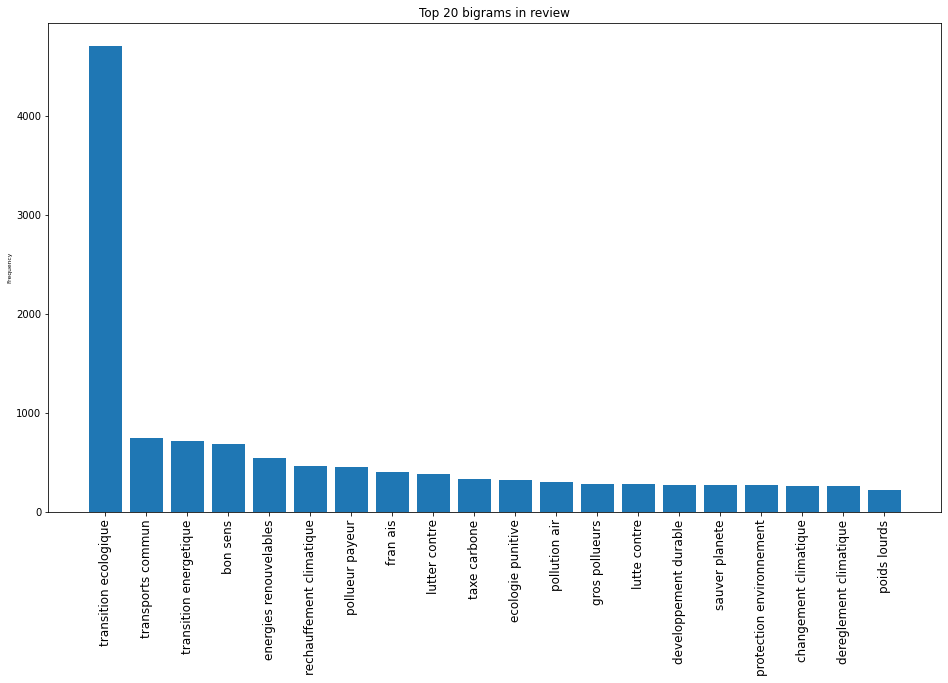

In [32]:
util.bigrams(reduced_dataset_df['clean_title'], 20)

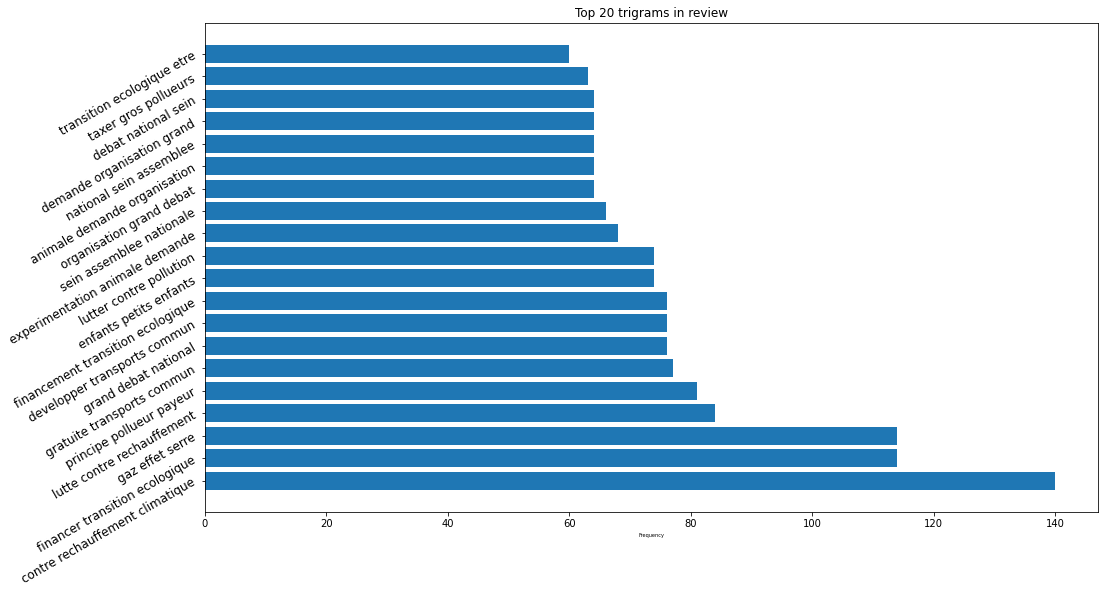

In [33]:
util.trigrams(reduced_dataset_df['clean_title'], 20)

**Nous pouvons remarquer que nous avons obtenu des résultats plus significatifs après avoir supprimé les stoprwords** 

On constate que les Français sont conscients de l'importance de la "transition écologique" avec environ 5000 réponses.

-----------------------------------------------------------------

<a class="anchor" id="7"></a> 

# 7.Analyse Problems Column :

In [34]:

tokenized_problems= util.tokenization(util.clean_X(reduced_dataset_df['problems']))
filtered_problems=util.rmStopwords(tokenized_problems)

util.N_mostFreq(filtered_problems , 50)

[('climatiques', 23985), ('dereglements', 23956), ('secheresse', 22915), ('crue', 22837), ('pollution', 20732), ('air', 18329), ('biodiversite', 17878), ('disparition', 16936), ('especes', 16806), ('certaines', 16147), ('problemes', 2542), ('climatique', 2045), ('eau', 1796), ('toutes', 1593), ('dechets', 1524), ('probleme', 1468), ('environnement', 1373), ('erosion', 1336), ('lies', 1276), ('importants', 1206), ('dereglement', 1203), ('autres', 1203), ('sols', 1188), ('important', 1178), ('ensemble', 1140), ('lie', 1126), ('etre', 1114), ('littoral', 1079), ('ressources', 991), ('planete', 929), ('rechauffement', 913), ('terre', 811), ('meme', 802), ('propositions', 726), ('pesticides', 690), ('consommation', 674), ('produits', 663), ('energie', 631), ('ci', 620), ('vie', 611), ('dessus', 584), ('agriculture', 537), ('donc', 537), ('etc', 505), ('sante', 494), ('autre', 494), ('reponses', 493), ('points', 488), ('ecologique', 485), ('pollutions', 479)]


In [35]:

reduced_dataset_df['clean_problems'] = [' '.join(words) for words in filtered_problems]
reduced_dataset_df.head()

,authorZipCode,title,problems,reponse_probleme,clean_title,clean_problems
0,97231,transition écologique,nan,nan,transition ecologique,
1,57000,La surpopulation,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...,surpopulation,problemes auxquels trouve confronte ensemble p...
2,34140,climat,"Les dérèglements climatiques (crue, sécheresse)",pour éviter les inondations obliger les rivera...,climat,dereglements climatiques crue secheresse
3,17400,POLLUTION AIR EAU,La pollution de l'air,Il faut taxer les gros pollueurs : Entreprises...,pollution air eau,pollution air
4,35430,Economie vs Ecologie,La biodiversité et la disparition de certaines...,"Changer notre mode de vie, impulser une nouvel...",economie vs ecologie,biodiversite disparition certaines especes


## Determine bigrams and trigrams * BEFORE * preprocessing for Problems

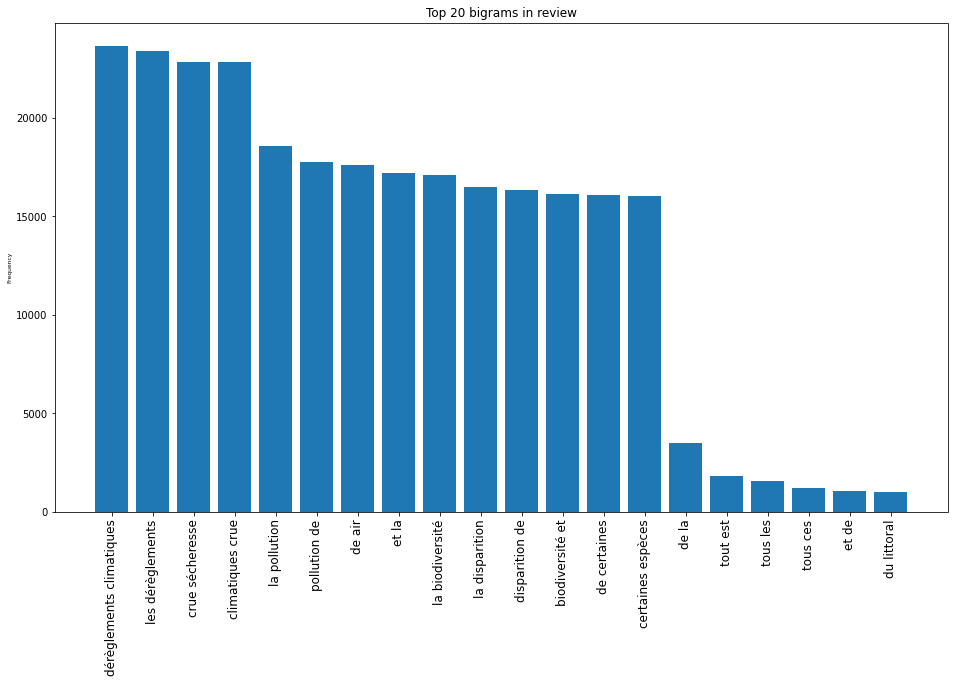

In [36]:
util.bigrams(reduced_dataset_df['problems'], 20)

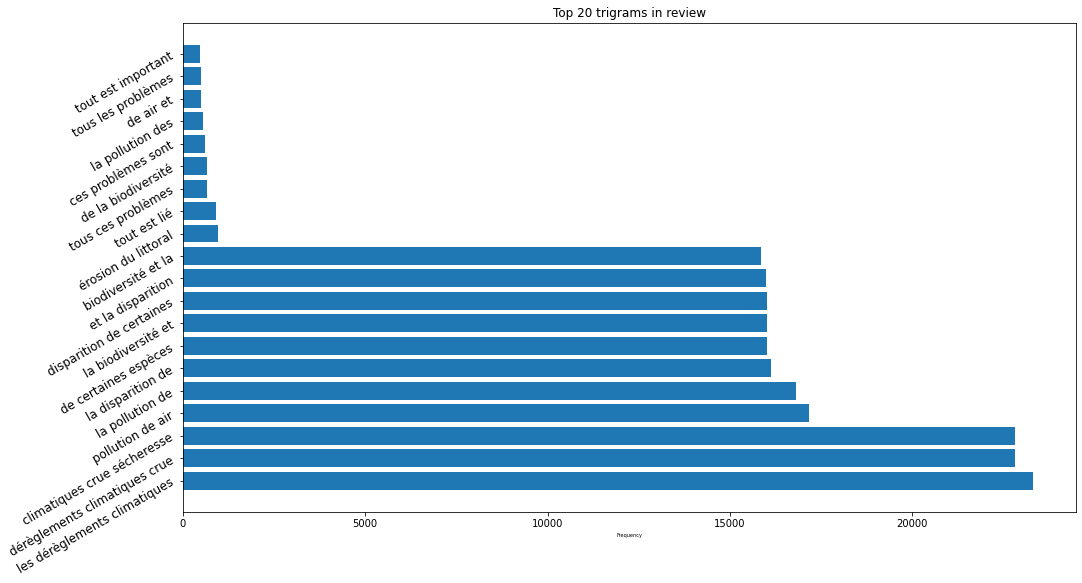

In [37]:
util.trigrams(reduced_dataset_df['problems'], 20)

## Determine bigrams and trigrams * AFTER * preprocessing for Problems

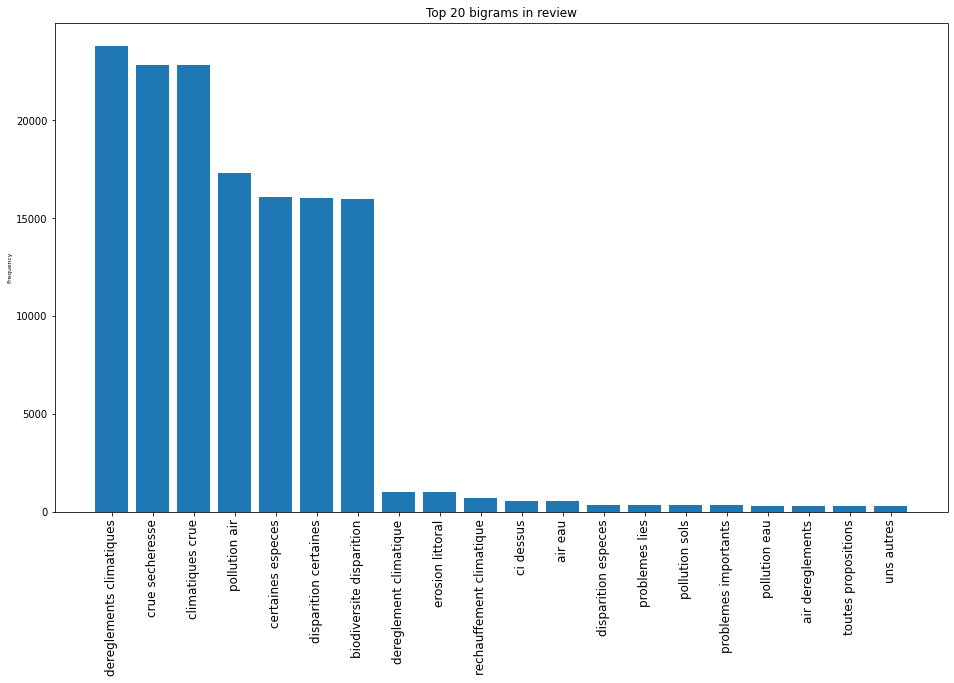

In [38]:
util.bigrams(reduced_dataset_df['clean_problems'], 20)

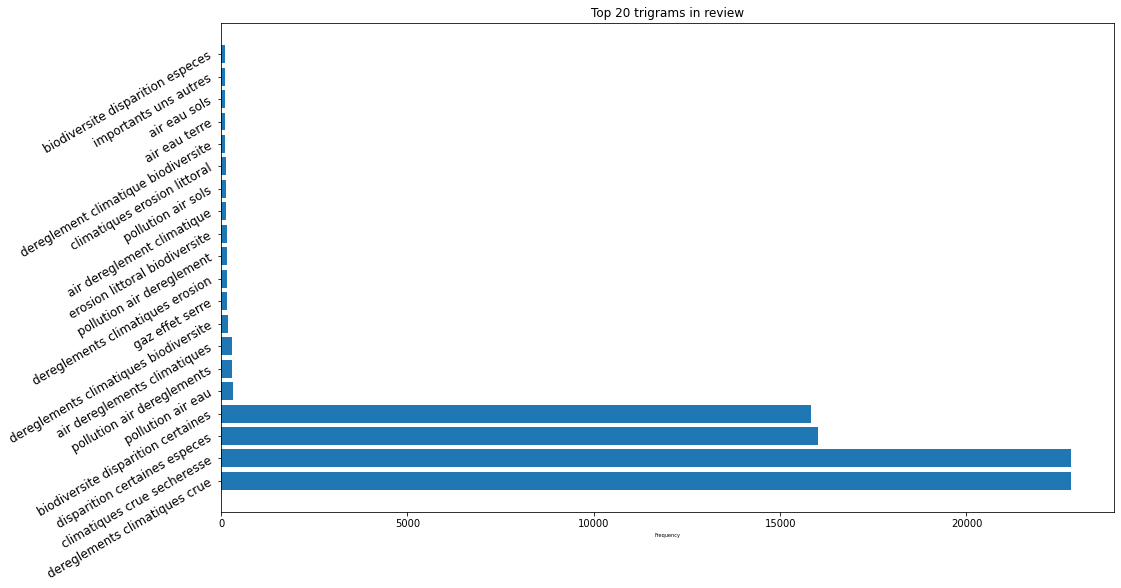

In [39]:
util.trigrams(reduced_dataset_df['clean_problems'], 20)

---------------------------------

<a class="anchor" id="8"></a> 

# 8. Analyse Response_problems Column :

In [41]:
clean_response=util.clean_X(reduced_dataset_df['reponse_probleme'])
tokenized_responses=util.tokenization(clean_response)
#print(tokenized_responses[0:10])
filtered_responses=util.rmStopwords(tokenized_responses)


In [42]:
util.N_mostFreq(filtered_responses,50)

[('produits', 15583), ('etre', 15076), ('transports', 11326), ('entreprises', 9788), ('developper', 9624), ('taxer', 9063), ('interdire', 8933), ('energie', 8645), ('france', 8624), ('consommation', 8414), ('pollution', 8218), ('agriculture', 8087), ('mettre', 8031), ('reduire', 7962), ('favoriser', 7905), ('production', 7861), ('transport', 7859), ('pays', 7760), ('ecologique', 7662), ('environnement', 7659), ('energies', 7573), ('exemple', 7376), ('vehicules', 7229), ('arreter', 7209), ('limiter', 6902), ('autres', 6836), ('place', 6797), ('meme', 6621), ('etc', 6125), ('transition', 5959), ('dechets', 5931), ('cette', 5919), ('etat', 5779), ('pesticides', 5776), ('niveau', 5597), ('eau', 5477), ('bio', 5382), ('tres', 5381), ('voiture', 5370), ('commun', 5340), ('donc', 5283), ('toutes', 5265), ('fran', 5125), ('politique', 5064), ('developpement', 4911), ('changer', 4907), ('vie', 4852), ('voitures', 4773), ('taxe', 4766), ('villes', 4721)]


In [43]:

reduced_dataset_df['clean_reponse_probleme'] = [' '.join(words) for words in filtered_responses]
reduced_dataset_df.head()

,authorZipCode,title,problems,reponse_probleme,clean_title,clean_problems,clean_reponse_probleme
0,97231,transition écologique,nan,nan,transition ecologique,,
1,57000,La surpopulation,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...,surpopulation,problemes auxquels trouve confronte ensemble p...,problemes auxquels trouve confronte ensemble p...
2,34140,climat,"Les dérèglements climatiques (crue, sécheresse)",pour éviter les inondations obliger les rivera...,climat,dereglements climatiques crue secheresse,eviter inondations obliger riverains communes ...
3,17400,POLLUTION AIR EAU,La pollution de l'air,Il faut taxer les gros pollueurs : Entreprises...,pollution air eau,pollution air,taxer gros pollueurs entreprises bateaux march...
4,35430,Economie vs Ecologie,La biodiversité et la disparition de certaines...,"Changer notre mode de vie, impulser une nouvel...",economie vs ecologie,biodiversite disparition certaines especes,changer mode vie impulser nouvelle economie ag...


In [44]:
util.N_mostFreq(filtered_responses, 50)


[('produits', 15583), ('etre', 15076), ('transports', 11326), ('entreprises', 9788), ('developper', 9624), ('taxer', 9063), ('interdire', 8933), ('energie', 8645), ('france', 8624), ('consommation', 8414), ('pollution', 8218), ('agriculture', 8087), ('mettre', 8031), ('reduire', 7962), ('favoriser', 7905), ('production', 7861), ('transport', 7859), ('pays', 7760), ('ecologique', 7662), ('environnement', 7659), ('energies', 7573), ('exemple', 7376), ('vehicules', 7229), ('arreter', 7209), ('limiter', 6902), ('autres', 6836), ('place', 6797), ('meme', 6621), ('etc', 6125), ('transition', 5959), ('dechets', 5931), ('cette', 5919), ('etat', 5779), ('pesticides', 5776), ('niveau', 5597), ('eau', 5477), ('bio', 5382), ('tres', 5381), ('voiture', 5370), ('commun', 5340), ('donc', 5283), ('toutes', 5265), ('fran', 5125), ('politique', 5064), ('developpement', 4911), ('changer', 4907), ('vie', 4852), ('voitures', 4773), ('taxe', 4766), ('villes', 4721)]


## Determine bigrams and trigrams *** BEFORE *** preprocessing for Response_problems

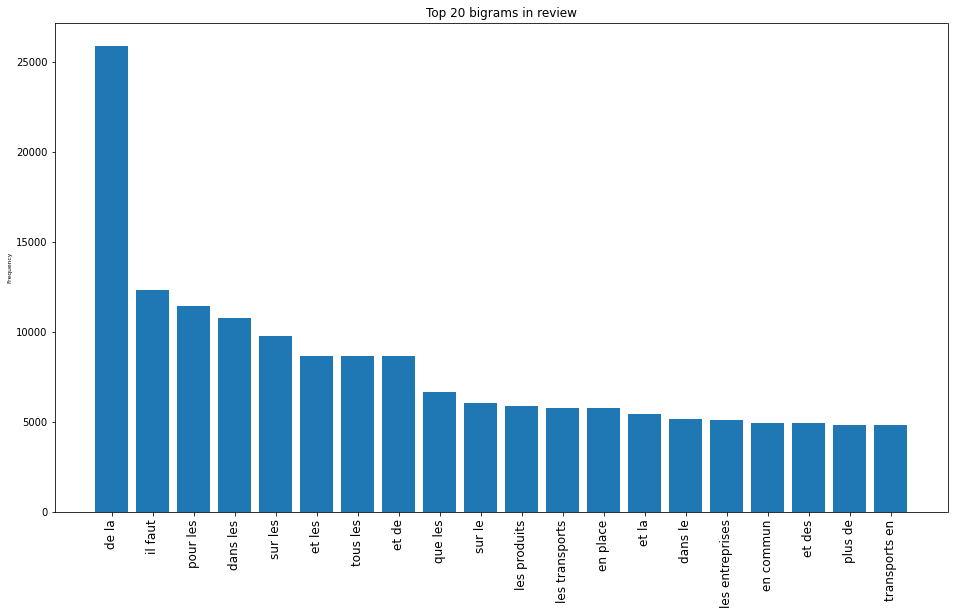

In [45]:
util.bigrams(reduced_dataset_df['reponse_probleme'], 20)

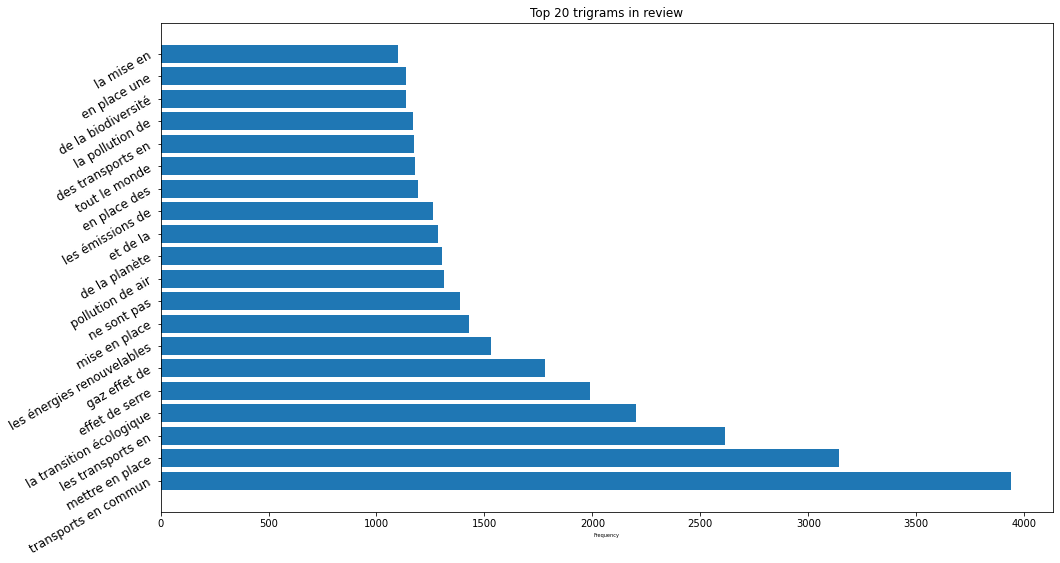

In [46]:
util.trigrams(reduced_dataset_df['reponse_probleme'], 20)

## Determine bigrams and trigrams *** AFTER *** preprocessing for Response_problems

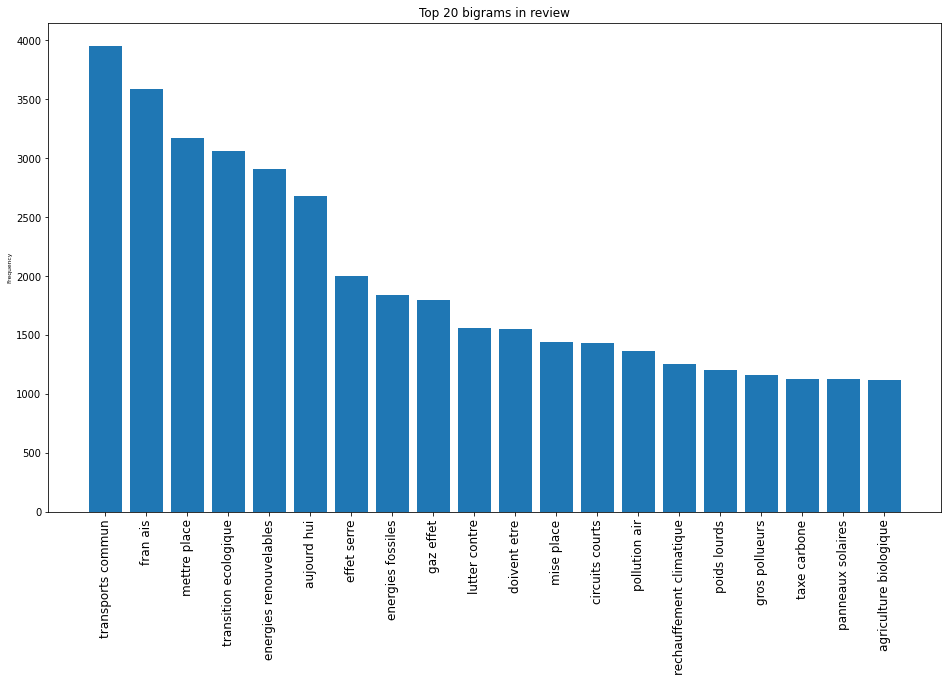

In [47]:
util.bigrams(reduced_dataset_df['clean_reponse_probleme'], 20)

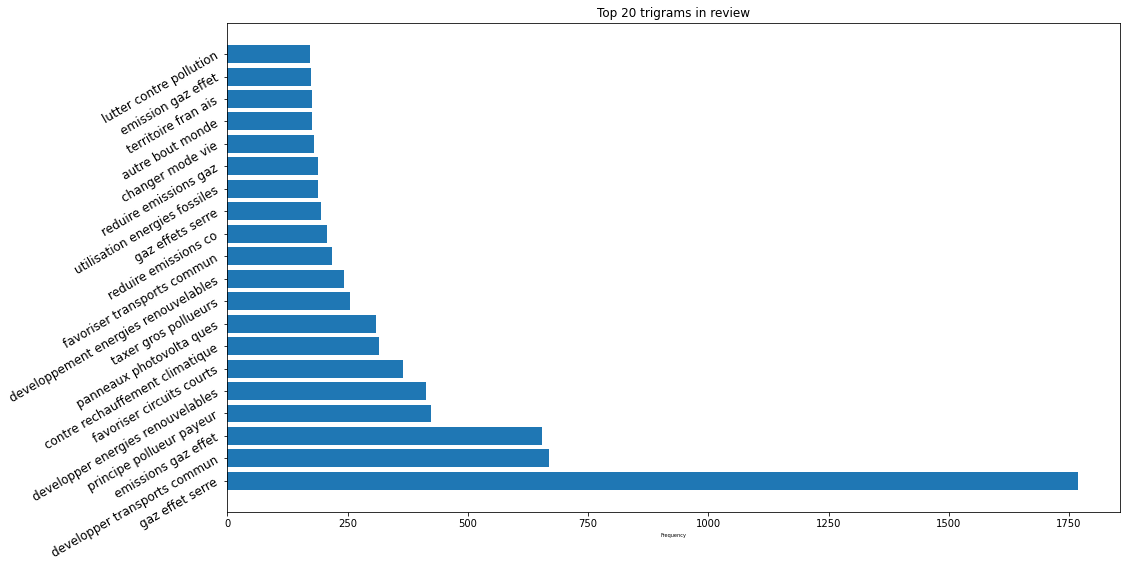

In [48]:
util.trigrams(reduced_dataset_df['clean_reponse_probleme'], 20)

___________________________